# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
training.get_word_Xlengths('LEG')

(array([[-49,  14, -17, 126],
        [-43,  17, -17, 126],
        [-39,  20, -17, 126],
        [-39,  20, -17, 126],
        [-39,  20, -17, 126],
        [-39,  20, -17, 126],
        [-39,  20, -17, 126],
        [-41,  26,  -4, 122]]), [8])

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [9]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [10]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()
df_std

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [11]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']
features = ['left-x', 'right-x', 'left-y', 'right-y']
for speaker in asl.df.speaker.unique():
    for f in features:
        asl.df[f + '-mean']= asl.df['speaker'].map(df_means[f])
        asl.df[f + '-std']= asl.df['speaker'].map(df_std[f])

asl.df[features_norm[0]] = (asl.df['right-x'] - asl.df['right-x-mean']) / asl.df['right-x-std']
asl.df[features_norm[1]] = (asl.df['right-y'] - asl.df['right-y-mean']) / asl.df['right-y-std']
asl.df[features_norm[2]] = (asl.df['left-x'] - asl.df['left-x-mean']) / asl.df['left-x-std']
asl.df[features_norm[3]] = (asl.df['left-y'] - asl.df['left-y-mean']) / asl.df['left-y-std']

In [12]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
asl.df[features_polar[0]] = np.sqrt((asl.df['right-x'] - asl.df['nose-x']) **2  + (asl.df['right-y' ] - asl.df['nose-y']) ** 2)
asl.df[features_polar[1]] = np.arctan2(asl.df['right-x'] - asl.df['nose-x'], asl.df['right-y'] - asl.df['nose-y'])
asl.df[features_polar[2]] = np.sqrt((asl.df['left-x'] - asl.df['nose-x']) **2  + (asl.df['left-y'] - asl.df['nose-y']) ** 2)
asl.df[features_polar[3]] = np.arctan2(asl.df['left-x'] - asl.df['nose-x'], asl.df['left-y'] - asl.df['nose-y'])
sample = (asl.df.ix[98,1][features_polar]).tolist()
sample

[113.35784048754634,
 0.079478244608206572,
 119.60351165413162,
 -0.10050059905462982]

In [13]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']
#asl.df['video'].unique()
#for video in asl.df['video'].unique():
#    asl.df.loc[(asl.df.video == video)]['left-x'].diff(1)
#for index in asl.df.index.levels[0]:
asl.df['delta-rx'] = asl.df.groupby(level=[0])['right-x'].diff(1).fillna(0)
asl.df['delta-ry'] = asl.df.groupby(level=[0])['right-y'].diff(1).fillna(0)
asl.df['delta-lx'] = asl.df.groupby(level=[0])['left-x'].diff(1).fillna(0)
asl.df['delta-ly'] = asl.df.groupby(level=[0])['left-y'].diff(1).fillna(0)

asl.df[features_delta].ix[97]

,delta-rx,delta-ry,delta-lx,delta-ly
frame,,,,
0,0.0,0.0,0.0,0.0
1,3.0,-2.0,0.0,0.0
2,1.0,-8.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,-1.0,-17.0,5.0,3.0
5,1.0,-13.0,0.0,0.0
6,-5.0,-15.0,1.0,4.0
7,0.0,-10.0,0.0,0.0
8,0.0,-16.0,0.0,0.0


In [14]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

# We will be adding distances between our reference point (nose and hands) as new features
features_handdist = ['hand_dist']
features_nosedist = ['lnose_dist', 'rnose_dist']
asl.df['hand_dist'] = np.sqrt((asl.df['left-x'] - asl.df['right-x']) ** 2 + (asl.df['left-y'] - asl.df['right-y']) ** 2)
asl.df['lnose_dist'] = np.sqrt((asl.df['left-x'] - asl.df['nose-x']) ** 2 + (asl.df['left-y'] - asl.df['nose-y']) ** 2)
asl.df['rnose_dist'] = np.sqrt((asl.df['right-x'] - asl.df['nose-x']) ** 2 + (asl.df['right-y'] - asl.df['nose-y']) ** 2)

# We will also be adding distance to nose from each of the hands

# TODO define a list named 'features_custom' for building the training set
features_custom = features_handdist + features_nosedist
asl.df.ix[98][features + features_custom]

,left-x,right-x,left-y,right-y,hand_dist,lnose_dist,rnose_dist
frame,,,,,,,
0,149,170,181,175,21.840330,119.603512,113.357840
1,149,170,181,175,21.840330,119.603512,113.357840
2,149,170,181,175,21.840330,119.603512,113.357840
3,149,170,181,175,21.840330,119.603512,113.357840
4,149,170,181,175,21.840330,119.603512,113.357840
5,149,170,181,175,21.840330,119.603512,113.357840
6,149,170,181,175,21.840330,119.603512,113.357840
7,149,170,181,175,21.840330,119.603512,113.357840
8,149,170,181,175,21.840330,119.603512,113.357840


**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** 
We have added 3 additional features to our set of features:

* Distance between hands: This will provide the distance between left and right hands. 
* Distances relative to the nose: This will provide the both distances between left hand and nose, and between right hand and nose

We have chosen these features because the pattern that can be build from an specific set of movements of a specific sign in ASL will be very different for each sign, as we are not only considering an axis, but the combination of both of them, and one relative to the other. 
For example: for the words "I" and "We", having the y axis as a feature gives us a pretty similar pattern for both of them, but if we chose the distance instead, the 2 very simmilar signs now become completely different when represented as the distance between the hands, or even as the distance between a hand and nose.
Moreover it can be easily computed from the information we already have (left and right hands coordinates)


<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [15]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.012s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [16]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433205


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [17]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #1
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [18]:
my_testword = 'JOHN'
model, logL = train_a_word(my_testword, 2, features_delta) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for JOHN is 2
hidden state #0
mean =  [-1.54687357 -4.26561817 -0.02343744 -0.16406205]
variance =  [  7.30252627  31.59350056   9.39008896  19.73088095]

hidden state #1
mean =  [-1.41050404 -5.27760178  0.          0.        ]
variance =  [  6.59141203e+00   3.54352858e+01   1.07181217e-05   1.07181217e-05]

logL = 595.1001365047282


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [19]:
%matplotlib inline

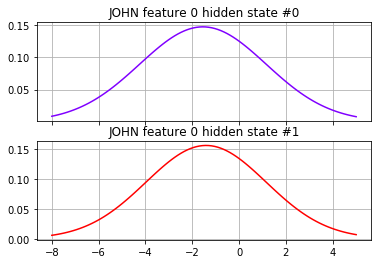

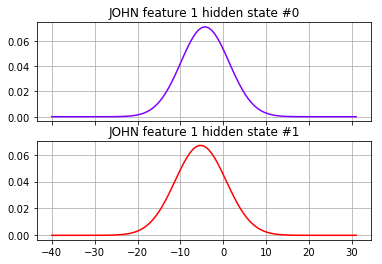

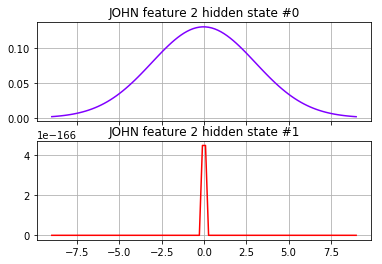

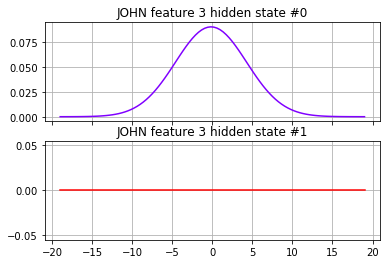

In [20]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))
            #ax.axis([-30, 30, 0, 0.2])
            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [21]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_delta)  # Experiment here with different feature sets defined in part 1
word = 'CHOCOLATE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for CHOCOLATE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [22]:
from sklearn.model_selection import KFold
from asl_utils import combine_sequences

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds
    aaa,bbb = combine_sequences(cv_train_idx, word_sequences)
    print("Word seqs all: ", word_sequences)
    print("Combined seqs all: ", aaa)

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Word seqs all:  [[[-26, 52, 22, 134], [-26, 52, 22, 134], [-25, 46, 22, 134], [-25, 46, 22, 134], [-22, 42, 22, 134], [-24, 39, 20, 131], [-23, 40, 21, 132], [-21, 39, 21, 131], [-20, 38, 22, 130], [-21, 38, 21, 130], [-22, 37, 20, 129], [-20, 36, 22, 128], [-21, 37, 21, 129]], [[-22, 44, 26, 133], [-18, 40, 26, 133], [-21, 36, 26, 133], [-21, 36, 26, 133], [-21, 36, 26, 133], [-21, 36, 26, 133], [-21, 36, 26, 133], [-21, 36, 26, 133], [-21, 36, 26, 133]], [[-20, 48, 26, 183], [-21, 46, 26, 183], [-20, 43, 30, 183], [-20, 43, 30, 183], [-18, 42, 32, 182], [-18, 38, 32, 178], [-15, 35, 35, 175], [-16, 36, 35, 175], [-14, 41, 35, 175], [-13, 38, 36, 172], [-13, 41, 36, 172], [-11, 39, 38, 170], [-16, 36, 38, 170]], [[-20, 36, -14, 126], [-22, 35, -14, 126], [-22, 35, -14, 126], [-21, 31, -14, 126], [-18, 30, -14, 126], [-15, 30, -14, 126], [-13, 30, -14, 126], [-13, 30, -14, 126], [-16, 28, -14, 126], [-16, 31, -14, 126], [-15, 33, -14

**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [23]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [24]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

In [25]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 7 states with time 0.4118503000063356 seconds
Training complete for BOOK with 5 states with time 4.235742066026432 seconds
Training complete for VEGETABLE with 2 states with time 1.9121628460125066 seconds
Training complete for FUTURE with 2 states with time 4.007953846012242 seconds
Training complete for JOHN with 12 states with time 44.053873305994784 seconds


In [26]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.37264333802158944 seconds
Training complete for BOOK with 8 states with time 2.21282132199849 seconds
Training complete for VEGETABLE with 9 states with time 0.8149335219932254 seconds
Training complete for FUTURE with 4 states with time 2.419535647990415 seconds
Training complete for JOHN with 13 states with time 23.302226873027394 seconds


In [27]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 1.6222747070132755 seconds
Training complete for BOOK with 15 states with time 5.010866351018194 seconds
Training complete for VEGETABLE with 15 states with time 4.005552539980272 seconds
Training complete for FUTURE with 15 states with time 4.66665701099555 seconds
Training complete for JOHN with 15 states with time 24.058365523989778 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

The first thing that we need to clarify is that Cross-Validation is a technique that could be easily combined with toher approaches (like BIC, AIC or DIC) as it just tries to reduce overfitting by reserving part of our labeled data for training and the rest for testing. So the discussion here will focus mostly on BIC vs DIC.

- BIC focuses on the likelihood of an input being recognized but penalizing the complexity of the model
- DIC doesn't care about the complexity and just focuses looking for the model that most uniquely identifies the given word

Taking this into account, DIC will usually provide a better accuracy with a training set where we have multiple copies of each word. As it focuses on trying to find the model that better uniquely identifies a word from the rest, having more copies of an specific word will provide better results. For our specific scenario, we dont have multiple copies for each of the words in our training sets. Some of them have only one or two copies. Thats the main reason why BIC may perform better (regarding accuracy) for the given feature set, as it doesnt suffer as much as DIC does from the lack of multiple copies of input words.

Also, DIC will require usually more computational power, because it wont penalize a model for being complex (what usually reflects on the time a model takes to recognize a given input word). So when deciding which Selector to use its important to consider not only the available computational power and time, but also the avaialble labeled data we have in our training set.

We will have the opporutnity to see the results of both BIC and DIC below when using them as part of our recognizer.

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [28]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 49.872s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [29]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_custom, SelectorBIC)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [30]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [31]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [45]:
# TODO Choose a feature set and model selector
features = features_polar # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5112359550561798
Total correct: 87 out of 178
Video  Recognized                                                    Correct
    2: *GO WRITE HOMEWORK                                            JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE GO *ARRIVE                                       JOHN CAN GO CAN
   12: JOHN *WHAT *GO1 CAN                                           JOHN CAN GO CAN
   21: JOHN *HOMEWORK WONT *FUTURE *GIVE1 *TEACHER *FUTURE *WHO      JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *FUTURE *WHO IX                                     JOHN LIKE IX IX IX
   28: JOHN *WHO *FUTURE *WHO IX                                     JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *GIRL *GIVE *MARY *MARY                      MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *VISIT *FUTURE1 *JOHN *MARY                              JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE BUY HOUSE       

In [33]:
# TODO Choose a feature set and model selector
features = features_polar 
model_selector = SelectorDIC 
# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5449438202247191
Total correct: 81 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
    7: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   12: JOHN *WHAT *JOHN CAN                                          JOHN CAN GO CAN
   21: JOHN *NEW *JOHN *PREFER *GIVE1 *WHAT *FUTURE *WHO             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *WHO IX                                           JOHN LIKE IX IX IX
   28: JOHN *FUTURE IX *FUTURE *LOVE                                 JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *IX *VISIT *GIVE *GIVE *MARY *MARY                            MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GO *GIVE *JOHN *MARY                                    JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE           

In [34]:
# TODO Choose a feature set and model selector
features = features_custom 
model_selector = SelectorCV 
# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5561797752808989
Total correct: 79 out of 178
Video  Recognized                                                    Correct
    2: *MARY *NEW *NEW                                               JOHN WRITE HOMEWORK
    7: JOHN *HAVE *IX *WHAT                                          JOHN CAN GO CAN
   12: JOHN *CAR *WHAT *WHAT                                         JOHN CAN GO CAN
   21: JOHN *BUY *JOHN *WHO *ARRIVE *CAR *FUTURE *FUTURE             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *FUTURE *FUTURE *WOMAN                              JOHN LIKE IX IX IX
   28: JOHN *FUTURE *FUTURE *WONT *MARY                              JOHN LIKE IX IX IX
   30: JOHN *WOMAN *LOVE *WOMAN IX                                   JOHN LIKE IX IX IX
   36: *VISIT *PREFER *GIRL *MARY LIKE *IX                           MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *VISIT *GIRL MARY LOVE                                   JOHN IX THINK MARY LOVE
   43: JOHN *NOT BUY HOUSE          

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**
A little tool that evaluates all the 12 combinations was built to help us out with the analysis. After analyzing the 12 combinations of Selectors and Feature sets, we came up with the following results for each of them. Metrics for **WER** and **Running Time** are provided below: 


WER | CV | DIC | BIC | AVERAGE
:---------|------------| ------------| ------------|
**Norm** | 0.646067416	| 0.595505618 |	0.612359551 | **0.617977528**
**Polar** | 0.58988764 | 0.54494382	| 0.511235955	| **0.548689139**
**Delta** | 0.617977528	| 0.623595506	| 0.612359551	| **0.617977528**
**Custom** | 0.556179775	| 0.58988764	| 0.561797753	| **0.56928839**
**AVERAGE** | **0.60252809** | **0.588483146**	| **0.574438202**	



TIME | CV | DIC | BIC | AVERAGE
:---------|------------| ------------| ------------|
**Norm** | 126.854624 | 218.7036579 | 75.7528348 |	**140.4370389**
**Polar** | 130.497833 | 233.8526018 | 80.26676893 | **148.2057346**
**Delta** |152.1018391 | 231.1726661 | 89.17322612 | **157.4825771**
**Custom** | 130.1124432 | 219.632822 | 74.337672 |	**141.3609791**
**AVERAGE** | **134.8916848** | **225.8404369** | **79.88262546**	

Note that the **Running Time** metrics are given just as a reference but are not considered as a decission point in out Feature-Selector combination selection.

Based on the WER results, we can see that the best combinations are **Polar-BIC**, **Polar-DIC** and **Custom-CV** (ordered from most accurate to less accurate). In average the best set of features within our dataset are **Polar** and **Custom** and the best Selector is **BIC** (the last one also the most efficient one regarding running time)

If we consider the results for Selector and Features separately we can come up with the following reasons why each of them may be working better for our domain:
 - **Polar feature set** is probably a beeter feature set compare to the others as we are, not only including the distance from the hands position relative to a common point but also the angle information (angle form by the hands position relative to the nose position and the x-axis (that has been swapped with y-axis in our case)). Normalized features are just performing a normalization among the different speakers and the proposed custom features (distance between hands) are just considering distances, being distance a feature that is more probable to be similar among different words. By including the distance to a reference point (nose location) as part of the custom feature we manage to improve its accuracy remarkably but not enough to beat polar features.
 - **BIC Selector** {See the explanation in Part2 as its directly applicable to the analysis here}

The main limitation we face here is that we are considering every word separately with out taking into account the contextual relationship between words when forming a sentence. As an example, prepositions will usually stand before nouns, so the probability of having a noun after a specific preposition is much higher than verb, or even than another preposition, as its not common to have 2 prepositions together (unless its a phrasal verb, for which case we could probably have a dictionary of phrasal verbs that could help us improve the recognition of such formations). A way of improving our WER is considering the above mentioned contextual relationship between words in a sentence by adding probabilities of 2 words (or even more) being together.

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [44]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 32.751s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [36]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

,0
0,-156.458281
1,-154.294126
2,-326.808725
3,-167.097017
4,-71.484164
